## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
from joblib import dump, load
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import preprocessing as pp

ModuleNotFoundError: No module named 'preprocessing'

## Training Functions

In [14]:
def dataset_split(features, labels_r, train_size=0.7, val_size=0.15):

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_r_tensor = torch.tensor(labels_r, dtype=torch.float32)
    # labels_c_tensor = torch.tensor(labels_c, dtype=torch.float32)
    

    # Combine features and labels into a custom Dataset

    dataset = TensorDataset(features_tensor, labels_r_tensor)
    

    length = len(dataset)
    train_len = int(length * train_size)
    val_len = int(length * val_size)
    test_len = length - train_len - val_len

    train_data, val_data, test_data = torch.utils.data.random_split(
        dataset, [train_len, val_len, test_len])

    print(train_data)
    return train_data, val_data, test_data


def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


def plot_training_curve(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.title("Train vs Validation Loss")
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    if train_accuracy != None: 
        plt.title("Train vs Validation Accuracy")
        plt.plot(train_accuracy, label="Train")
        plt.plot(val_accuracy, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
        
        

## Regression Neural Net

In [17]:
def train_regression(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=30, checkpoints=True, plot=True):

    torch.manual_seed(1)

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        val_data, batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    start = time.time()

    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, labels in train_loader:
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        with torch.no_grad():
            model.eval()
            val_loss = 0.0

            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
            val_loss /= len(val_loader)

            val_losses.append(val_loss)

        # scheduler.step(val_loss)

        if checkpoints:
            print(f"_______________________Epoch {epoch + 1}_______________________")

            print("Train loss: {} | Validation loss: {} ".format(
                train_losses[epoch],
                val_losses[epoch]
            ))
            # print("Train acc: {} | Validation acc: {} ".format(
            #     train_accuracies[epoch],
            #     val_accuracies[epoch]
            # ))

    if not checkpoints:
        print(f"_______________________Epoch {num_epochs}_______________________")

        print("Train loss: {} | Validation loss: {} ".format(
            train_losses[num_epochs-1],
            val_losses[num_epochs-1]
        ))
        # print("Train acc: {} | Validation acc: {} ".format(
        #     train_accuracies[num_epochs-1],
        #     val_accuracies[num_epochs-1]
        # ))

    print('Finished Training')
    elapsed_time = time.time() - start
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # make sure to plot the training curves
    if plot:
        plot_training_curve(train_losses, val_losses, None, None)
    return train_loss, val_loss

## Classification Neural Net

In [16]:
def train_regression(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=30, checkpoints=True, plot=True):
    train_accuracies = []
    train_losses = []
    
    val_accuracies = []
    val_losses = []
    train_loader = DataLoader(train_data, batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size, shuffle=True)
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()    
    
    ## train:
    
    start = time.time()
    for epoch in range(num_epochs):
        train_loss = 0.0 
        train_accuracy = 0.0
        
        for inputs, labels in train_loader: 
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1) ## returns (values, indices). we want to take the indices of the maximum probabilities along the class axis
            train_accuracy += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        
        train_losses[epoch] = train_loss
        train_accuracies[epoch] = train_accuracies
        

        with torch.no_grad:
            for inputs, labels in val_loader:
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1) 
                val_accuracy += (predicted == labels).sum().item()

                        
            val_loss /= len(train_loader)
            val_accuracy /= len(train_loader)
            
            val_losses[epoch] = train_loss
            val_accuracies[epoch] = val_accuracy
            
        
        if checkpoints:
            print(f"_______________________Epoch {epoch + 1}_______________________")

            print("Train loss: {} | Validation loss: {} ".format(
                train_losses[epoch],
                val_losses[epoch]
            ))
            print("Train acc: {} | Validation acc: {} ".format(
                train_accuracies[epoch],
                val_accuracies[epoch]
            ))

    if not checkpoints:
        print(f"_______________________Epoch {num_epochs}_______________________")

        print("Train loss: {} | Validation loss: {} ".format(
            train_losses[num_epochs-1],
            val_losses[num_epochs-1]
        ))
        print("Train acc: {} | Validation acc: {} ".format(
            train_accuracies[num_epochs-1],
            val_accuracies[num_epochs-1]
        ))

    print('Finished Training')
    elapsed_time = time.time() - start
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
        
    if plot:
        plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies)
    

## Architecture

In [18]:
class my_network(nn.Module):
    def __init__(self, sz=[64, 100, 128], inp=54, out=1):
        super(my_network, self).__init__()
        self.layer_sizes = [inp] + sz + [out]
        self.name = "layer4linear"

        self.fc1 = nn.Linear(inp, sz[0])
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(sz[0], sz[1])
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(sz[1], sz[2])
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(sz[2], out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def get_number_params(self):
        num_params = 0
        for i in range(len(self.layer_sizes)-1):
            num_params += self.layer_sizes[i] * \
                self.layer_sizes[i+1] + self.layer_sizes[i+1]
        return num_params

test = my_network()
print(test.get_number_params())

23077


## Loading Data

In [19]:
my_path = '/Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/cubic_F_225_v2'

my_loaded_data = pp.load_data(my_path)

>> Retrieving: cubic_F_225_v2_regression_1500.joblib
>> Retrieving: cubic_F_225_v2_material_ids1500.joblib
>> Retrieving: cubic_F_225_v2_labels_classification_system_1500.joblib
>> Retrieving: cubic_F_225_v2_labels_classification_bravais_1500.joblib
>> Retrieving: cubic_F_225_v2_features_1500.joblib
>> Retrieving: cubic_F_225_v2_labels_classification_space_1500.joblib
>> Sanity Check: printing element(s) 1 of 1500 from each array

[[3.43, 3.43, 3.43, 60.0, 60.0, 60.0]]
[(MPID(mp-1008785), 'RuO2')]
['Cubic']
['F']
[[5.502, 3.891, 7.781, 5.502, 3.891, 0.785, 0.0, 0.786, 0.785, 5.502, 4.562, 2.383, 3.891, 2.383, 0.44, 0.515, 0.616, 0.616, 5.502, 3.891, 7.781, 5.502, 3.891, 0.785, 0.0, 0.786, 0.785, 5.502, 4.562, 2.383, 3.891, 2.383, 0.44, 0.515, 0.616, 0.616, 5.502, 2.383, 3.891, 2.383, 5.502, 0.955, 0.616, 0.616, 0.955, 5.502, 3.891, 7.781, 5.502, 3.891, 0.785, 0.0, 0.786, 0.785]]
[225]


In [22]:
print(len(my_loaded_data[4]))


1500


In [21]:
no_angles_regression = []

## Filter through side lengths only
for element in my_loaded_data[0]:
    no_angles_regression.append(element[:1])

train_data, val_data, test_data = dataset_split(
    my_loaded_data[4], no_angles_regression)

### Sanity Check

In [63]:
# for data in my_loaded_data:
#     print(data[:1])

In [64]:

# for i in range(0, 10): #len(my_loaded_data[0])):
#     print(my_loaded_data[2][i])
#     print(my_loaded_data[0][i])
#     my_loaded_data[0][i].append(my_loaded_data[2][i])
#     # print(my_loaded_data[0][i])


In [65]:
# for i in range(0, 10): #len(my_loaded_data[0])):
#     print(my_loaded_data[2][i])
#     print(my_loaded_data[0][i])

## Training

_______________________Epoch 40_______________________
Train loss: 0.9473778623523135 | Validation loss: 1.5434488086029887 
Finished Training
Total time elapsed: 0.96 seconds


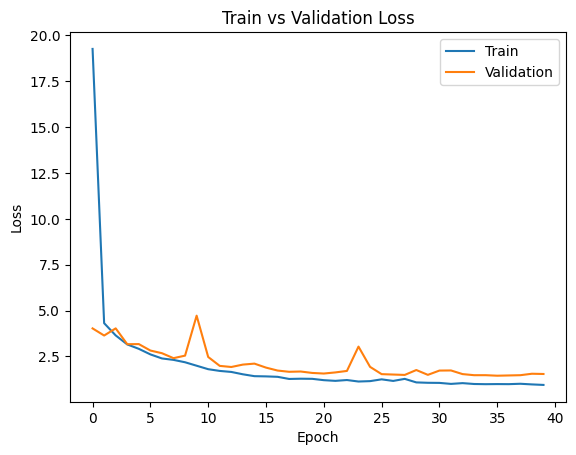

(0.9473778623523135, 1.5434488086029887)

In [28]:
model = my_network()
train_regression(model, train_data, val_data,
      batch_size=32, learning_rate=0.0005, num_epochs=40, checkpoints=False)

In [29]:
model.eval()

test_loss = 0.0
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

gt_list = []
preds_list = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        outputs = model(inputs)
        # print(labels, outputs)
        gt_list.append(labels.tolist())
        preds_list.append(outputs.tolist())

        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_data)
print(f'Test Loss: {test_loss}')

percent_diffs = []
for i in range(len(gt_list)):
    for j in range(len(gt_list[i])):
        GT = round(gt_list[i][j][0], 2)
        PD = round(preds_list[i][j][0], 2)
        DIFF = round(GT - PD, 2)
        PDIFF = round(abs(GT - PD) / GT * 100, 2)
        percent_diffs.append(PDIFF)
        
        print(f"GT: {GT:>5.2f}    PD: {PD:>5.2f}    DIFF: {DIFF:>5.2f}    %DIFF: {PDIFF:>5.2f}%")

# Acceptable % difference <= 10%

percent_diffs = np.array(percent_diffs)

# beam directions 
# classifications
# monoclinic (7 > )
# thurs 

Test Loss: 0.087092428472307
GT:  2.68    PD:  5.22    DIFF: -2.54    %DIFF: 94.78%
GT:  6.01    PD:  6.08    DIFF: -0.07    %DIFF:  1.16%
GT:  5.18    PD:  5.34    DIFF: -0.16    %DIFF:  3.09%
GT:  7.32    PD:  8.02    DIFF: -0.70    %DIFF:  9.56%
GT:  7.58    PD:  6.00    DIFF:  1.58    %DIFF: 20.84%
GT:  7.19    PD:  6.65    DIFF:  0.54    %DIFF:  7.51%
GT:  4.84    PD:  5.08    DIFF: -0.24    %DIFF:  4.96%
GT:  6.21    PD:  4.99    DIFF:  1.22    %DIFF: 19.65%
GT:  4.50    PD:  4.80    DIFF: -0.30    %DIFF:  6.67%
GT:  6.50    PD:  6.46    DIFF:  0.04    %DIFF:  0.62%
GT:  4.75    PD:  4.93    DIFF: -0.18    %DIFF:  3.79%
GT:  4.95    PD:  5.16    DIFF: -0.21    %DIFF:  4.24%
GT:  6.11    PD:  6.11    DIFF:  0.00    %DIFF:  0.00%
GT:  4.86    PD:  4.84    DIFF:  0.02    %DIFF:  0.41%
GT:  3.11    PD:  4.98    DIFF: -1.87    %DIFF: 60.13%
GT:  4.91    PD:  5.30    DIFF: -0.39    %DIFF:  7.94%
GT:  5.58    PD:  5.62    DIFF: -0.04    %DIFF:  0.72%
GT:  6.01    PD:  6.08    DIFF: -0.0

In [30]:
print(f"Percentage of inacceptable predictions: {round(len(percent_diffs[percent_diffs > 10])/len(percent_diffs) * 100, 3)}%")
print(f"Percentage of acceptable predictions: {round(len(percent_diffs[percent_diffs <= 10])/len(percent_diffs) * 100, 3)}%")
print(f"Average percentage difference for acceptable predictions: {round(percent_diffs[percent_diffs <= 10].mean(), 3)}%")

Percentage of inacceptable predictions: 24.444%
Percentage of acceptable predictions: 75.556%
Average percentage difference for acceptable predictions: 3.755%


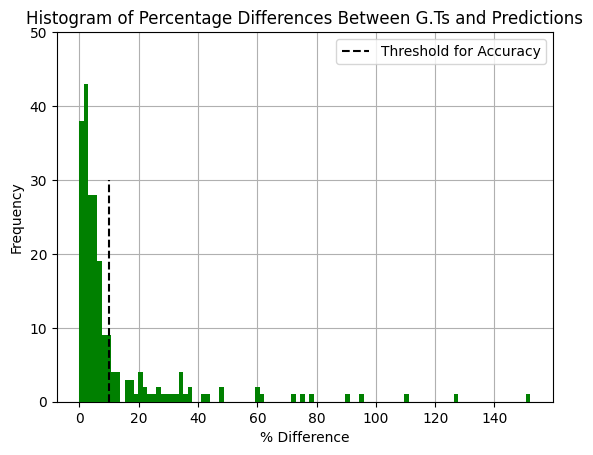

In [34]:
plt.title("Histogram of Percentage Differences Between G.Ts and Predictions")
plt.grid(zorder=0)
plt.hist(percent_diffs, bins=100, zorder=5, color='g')
plt.ylim([0,50])
plt.vlines(x=10, ymin = 0, ymax = 30, color='k', linestyles='--', zorder=6, label="Threshold for Accuracy")
plt.xlabel("% Difference")
plt.ylabel("Frequency")
plt.legend(loc="best")